In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import namedtuple

import seaborn as sns

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
### General Processing

In [3]:
main = pd.read_excel('movantanalysis.xlsx', sheet_name = 'KM Data Edits')
datapull = pd.read_excel('movantanalysis.xlsx', sheet_name = 'Data Pull Sheet')
aums = pd.read_excel('movantanalysis.xlsx', sheet_name = 'All Institution AUMs')
removed = pd.read_excel('movantanalysis.xlsx', sheet_name = 'Removed cases')

In [4]:
movant_categories = main["Movant ID"].str.split(".", n=2, expand = True)
main['Movant Group'] = movant_categories[0]+movant_categories[1]

In [5]:
main = main.merge(aums[['Institutional Movant', 'AUM']], how = 'left', left_on = 'Movant', right_on = 'Institutional Movant')

In [6]:
main = main.merge(datapull[['Ticker','Damage Bucket', "Filing Firm", "Lead Plaintiff"]], how = 'left', on = 'Ticker')

In [7]:
main = main.loc[:2866,:]

In [8]:
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("InS", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ins", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("G-mix", "G-Mix")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ind", "Ind")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("g-Ind", "G-Ind")

In [9]:
main["Small Case"] = 0
main.loc[main["Damage Bucket"].isin(["A","B"]), "Small Case"] = 1 
main.loc[main["Lead Plaintiff"].isna(),"Lead Plaintiff"] = "None"

In [10]:
def win(a, b):
    if a in b: return 1
    else: return 0

main = main.assign(win = main.apply(lambda row: win(row["Movant"], row["Lead Plaintiff"]), axis =1))

In [11]:
main["unopposed"] = 0
main.loc[main["Contested/\nUncontested"]=="Uncontested", "unopposed"] = 1

In [12]:
#main["AUM"] = main.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)
#main["Movant Loss"] = main.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)

### I. MOVANT ANALYSIS BY REPORTED DAMAGES BY BUCKET

#### I. A. Number of Cases by Bucket

In [13]:
data_1a = datapull['Damage Bucket'].value_counts()

In [14]:
y_val = data_1a.sort_index()
x_val = data_1a.sort_index().index

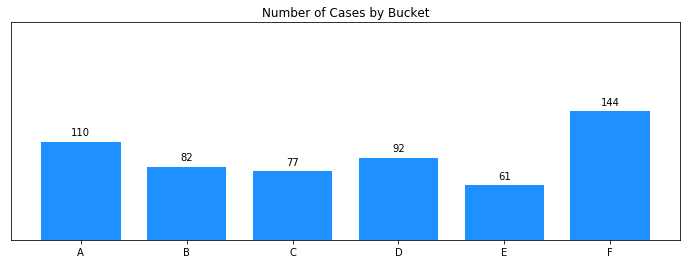

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Cases by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

ax.set_ylim([0,y_val.max()+ 100])

rects = ax.patches

ax.yaxis.set_ticks_position('none')

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### I.B. Analysis by Bucket

In [16]:
data_1b = datapull[['Damage Bucket', 'Docket Number','Total Damages', '% of Total Damages']].dropna()
data_1b['Total Damages'] = pd.to_numeric(data_1b['Total Damages'], errors='coerce').fillna(0)
data_1b['% of Total Damages'] = pd.to_numeric(data_1b['% of Total Damages'], errors='coerce').fillna(0)

In [17]:
data_1b_total = data_1b[['Damage Bucket', 'Docket Number','Total Damages']]
data_1b_describe_total = data_1b_total.pivot(index = 'Docket Number', columns = 'Damage Bucket', values = 'Total Damages')
data_1b_describe_total = data_1b_describe_total.describe()
data_1b_describe_total = pd.concat([data_1b_describe_total, pd.DataFrame(np.sort(data_1b_total.pivot(index = 'Docket Number', columns = 'Damage Bucket', values = 'Total Damages').fillna(0), axis = 0)[-2:,:], columns = data_1a.sort_index().index, index = ['Largest', '2nd Largest'])])

In [18]:
data_1b_bps = data_1b[['Damage Bucket', 'Docket Number','% of Total Damages']]
data_1b_describe_bps = data_1b_bps.pivot(index = 'Docket Number', columns = 'Damage Bucket', values = '% of Total Damages')
data_1b_describe_bps = data_1b_describe_bps.describe()

In [19]:
x_val = np.sort(data_1b['Damage Bucket'].unique())

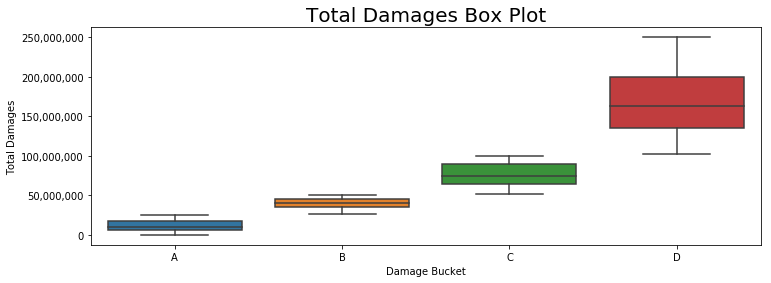

In [20]:
#### plt.clf()
plt.figure(figsize=(12,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[~data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[:4], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

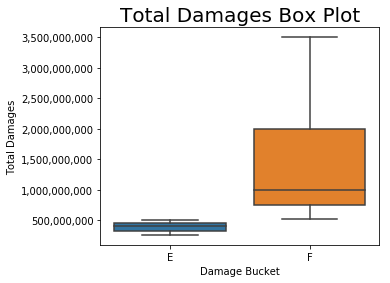

In [21]:
plt.figure(figsize=(5,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[4:6], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

In [22]:
pd.options.display.float_format = '${:,.0f}'.format
print("By Total Damage")
data_1b_describe_total

By Total Damage


Damage Bucket,A,B,C,D,E,F
count,$110,$82,$77,$92,$61,$144
mean,"$11,848,636","$38,815,854","$75,870,130","$171,467,391","$392,967,213","$2,385,520,833"
std,"$7,383,037","$6,610,158","$14,436,203","$42,049,539","$76,220,506","$4,046,534,549"
min,$0,"$26,000,000","$52,000,000","$102,000,000","$260,000,000","$515,000,000"
25%,"$5,625,000","$35,000,000","$65,000,000","$135,000,000","$325,000,000","$747,500,000"
50%,"$10,000,000","$40,000,000","$75,000,000","$162,500,000","$400,000,000","$1,000,000,000"
75%,"$17,750,000","$45,000,000","$90,000,000","$200,000,000","$450,000,000","$2,000,000,000"
max,"$25,000,000","$50,000,000","$100,000,000","$250,000,000","$500,000,000","$25,000,000,000"
Largest,"$25,000,000","$50,000,000","$100,000,000","$250,000,000","$500,000,000","$25,000,000,000"
2nd Largest,"$25,000,000","$50,000,000","$100,000,000","$250,000,000","$500,000,000","$25,000,000,000"


In [23]:
pd.options.display.float_format = '{:,.2%}'.format
print("By BPS")
data_1b_describe_bps 

By BPS


Damage Bucket,A,B,C,D,E,F
count,"11,000.00%","8,200.00%","7,700.00%","9,200.00%","6,100.00%","14,400.00%"
mean,2.82%,1.14%,0.34%,0.49%,0.30%,0.40%
std,5.56%,2.06%,0.85%,1.02%,0.60%,1.03%
min,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
25%,0.09%,0.05%,0.01%,0.04%,0.01%,0.00%
50%,0.70%,0.33%,0.09%,0.16%,0.06%,0.04%
75%,2.57%,1.42%,0.29%,0.40%,0.28%,0.23%
max,34.72%,13.61%,6.80%,6.43%,3.06%,7.29%


#### I.C. Win-Loss Analysis

In [24]:
data_1c = main[["Movant", "Damage Bucket", "Type", "win", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]]

#### I.C.1 Largest Movant

In [25]:
data_1c1_wins = main.groupby("Movant")["win"].agg(["sum", "count"])
data_1c1_wins["win_rate"] = data_1c1_wins["sum"]/data_1c1_wins["count"]
data_1c1_losses = main.groupby("Movant")["Movant Loss"].sum()

In [26]:
data_1c1_largest = data_1c1_losses[data_1c1_losses == data_1c1_losses.max()].index

In [27]:
pd.options.display.float_format = '{:,.2f}'.format
print("The number of wins, cases and win rate of the largest movant is")
data_1c1_wins[data_1c1_wins.index.isin(data_1c1_largest)]

The number of wins, cases and win rate of the largest movant is


,sum,count,win_rate
Movant,,,
Union Asset Management Holding AG,4,7,0.57


In [28]:
#### I.C.2 Win Rate by Movant Category

In [29]:
data_1c2 = data_1c.groupby("Type")["win"].agg(["sum", "count"])
data_1c2["win_rate"] = data_1c2["sum"]/data_1c2["count"]

In [30]:
x_val = data_1c2.index
y_val = data_1c2.win_rate

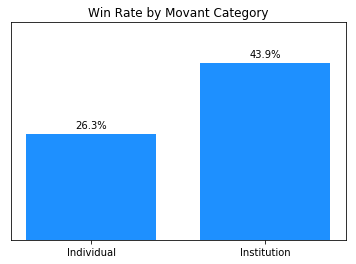

In [31]:

fig, ax = plt.subplots(figsize=(6,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [32]:
#### I.C.3. Win Rate By Bucket

In [33]:
data_1c3 = data_1c.groupby("Damage Bucket")["win"].agg(["sum", "count"])
data_1c3["win_rate"] = data_1c3["sum"]/data_1c3["count"]

In [34]:
x_val = data_1c3.index
y_val = data_1c3.win_rate

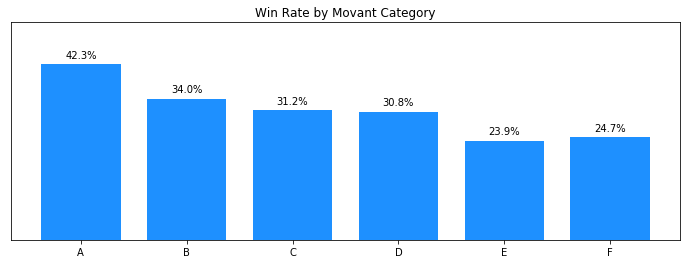

In [35]:

fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [36]:
#### I.C.4. Win Rate By Bucket by Movant Type

In [37]:
data_1c4 = data_1c.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Damage Bucket"])["win"].agg(["sum", "count"])
data_1c4["win_rate"] = data_1c4["sum"]/data_1c4["count"]

In [38]:
x_val = data_1c4.index
y_val = data_1c4.win_rate

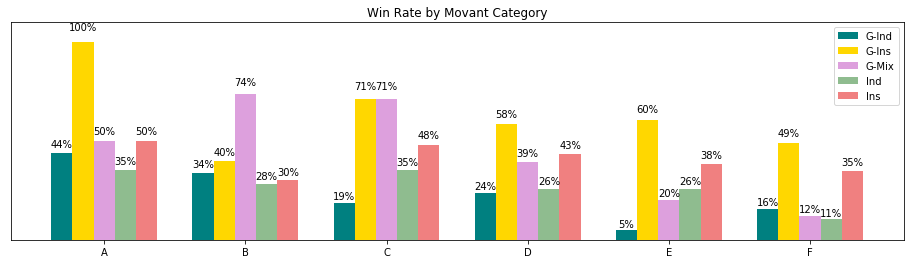

In [43]:
fig, ax = plt.subplots(figsize=(16,4))
width = 0.15
ind = np.arange(6)
legends = ["G-Ind", "G-Ins", "G-Mix", "Ind", "Ins"]
buckets = ["A", "B", "C", "D", "E", "F"]
colors=['teal', 'gold', 'plum', 'darkseagreen', 'lightcoral', "mediumorchid"]

plt.title('Win Rate by Movant Category')
plt.yticks([], [])

rects = []

for i in range(len(legends)):
    box = ax.bar(ind + width*(i-1), y_val[legends[i]], width, color = colors[i], label = legends[i])
    rects.append(box)

plt.legend([i for i in rects], legends)


ax.set_xticks(ind+width)
ax.set_xticklabels(buckets)
ax.yaxis.set_ticks_position('none')
ax.set_ylim([0,y_val.max()+ 0.1])

def autolabel(i):
    for rect in i:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, "{:,.0%}".format(h),
                ha='center', va='bottom')
        
for i in rects:
    autolabel(i)



plt.show()

### II. ANALYSIS BY TYPE OF MOVANT

#### II. A. Number of Movants by Bucket

In [44]:
data_2a = main["Damage Bucket"].value_counts()

In [45]:
y_val = data_2a.sort_index()
x_val = data_2a.sort_index().index

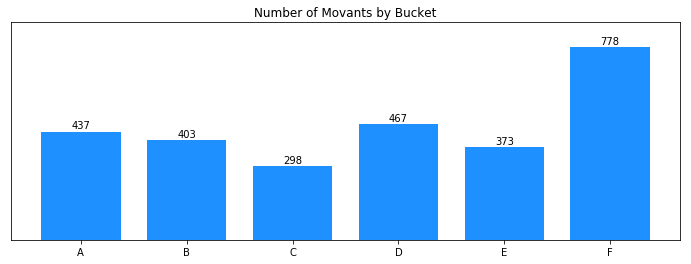

In [46]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### II.B. Number of Movants by Case

In [47]:
data_2b = main.groupby("Ticker")["Movant ID"].count().reset_index()
data_2b_describe = data_2b.describe()

In [48]:
pd.options.display.float_format = '{:.2f}'.format
data_2b_describe

,Movant ID
count,549.00
mean,5.22
std,4.03
min,1.00
25%,2.00
50%,4.00
75%,7.00
max,26.00


#### II.C. Movant By Type By Bucket

In [49]:
data_2c = main[["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant ID"]]

In [50]:
data_2c_grouped = data_2c.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant ID"].count().reset_index()

In [51]:
data_2c_grouped

,Damage Bucket,"Type (Ind, Ins, G-Ind, G-Ins, G-Mix)",Movant ID
0,A,G-Ind,244
1,A,G-Ins,8
2,A,G-Mix,14
3,A,Ind,153
4,A,Ins,18
5,B,G-Ind,238
6,B,G-Ins,5
7,B,G-Mix,19
8,B,Ind,121
9,B,Ins,20


#### II.D. For Groups

In [52]:
data_2d = main[["Movant Group", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant Loss", "Movant ID", "win"]]
data_2d_groupcount = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant ID"].nunique()/data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Group"].nunique()
data_2d_groupcount = data_2d_groupcount.append(pd.Series(data_2d["Movant ID"].nunique()/data_2d["Movant Group"].nunique(), index = ["Total"]))
data_2d_loss = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Loss"].mean()
data_2d_loss = data_2d_loss.append(pd.Series(main["Movant Loss"].mean(), index = ["Total"]))
data_2d_winrate = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].count()/data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].sum()
data_2d_winrate = data_2d_winrate.append(pd.Series(main["win"].count()/main["win"].sum(), index = ["Total"]))

In [67]:
data_2d = pd.concat([data_2d_groupcount, data_2d_loss, data_2d_winrate], axis = 1)
data_2d.columns = ["Avg # of Members for Each Type", "Avg Losses", "Win Rate"]
data_2d["Avg Losses"] = data_2d.apply(lambda x: '${:,.2f}'.format(x["Avg Losses"]), axis = 1)

In [70]:
print("Statistics by Type")
pd.options.display.float_format = '{:,.2f}'.format
data_2d

Statistics by Type


,Avg # of Members for Each Type,Avg Losses,Win Rate
G-Ind,2.88,"$124,115.89",3.67
G-Ins,2.39,"$1,940,241.80",1.80
G-Mix,3.02,"$825,217.99",3.07
Ind,1.07,"$282,381.10",3.93
Ins,1.04,"$2,354,680.71",2.60
Total,1.65,"$685,731.86",3.25


#### II.E. For Unopposed Lead Plaintiff Motions

In [71]:
data_2e = main[main["unopposed"]==1][["Damage Bucket","Movant","Movant Loss"]]

#### III.E.1. Number of Unopposed by Bucket

In [72]:
data_2e1 = data_2e.groupby("Damage Bucket")["Movant"].count().reset_index()

In [73]:
data_2e1

,Damage Bucket,Movant
0,A,48
1,B,27
2,C,32
3,D,20
4,E,13
5,F,22


#### II.E.2 Average Loss of Unopposed by Bucket

In [75]:
data_2e2 = data_2e.groupby("Damage Bucket")["Movant Loss"].mean().reset_index()
data_2e2["Movant Loss"] = data_2e2.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)


In [76]:
pd.options.display.float_format = '${:,.2}'.format
data_2e2

,Damage Bucket,Movant Loss
0,A,"$36,971.69"
1,B,"$65,563.61"
2,C,"$73,900.11"
3,D,"$114,261.82"
4,E,"$195,680.14"
5,F,"$3,828,990.34"


#### II.F. Fight Analysis

In [77]:
data_2f = main[["Small Case", "Type", "win"]]

In [78]:
data2f_wins = data_2f.groupby(["Small Case", "Type"])["win"].agg(["sum", "count"])
data2f_wins["win_rate"] = data2f_wins["sum"]/  data2f_wins["count"]

In [79]:
pd.options.display.float_format = '{:.1%}'.format
data2f_wins["win_rate"].reset_index()

,Small Case,Type,win_rate
0,0,Individual,20.4%
1,0,Institution,42.7%
2,1,Individual,36.8%
3,1,Institution,56.1%


### III. ANALYSIS BY INSTITUTIONAL MOVEMENT TYPE

#### III. A. Institutional Movants by Bucket

In [80]:
data_3 = main[main["Type"]== "Institution"]

In [81]:
data_3a = data_3.groupby('Damage Bucket')['Institutional Movant'].count()

In [82]:
y_val = data_3a.sort_index()
x_val = data_3a.sort_index().index

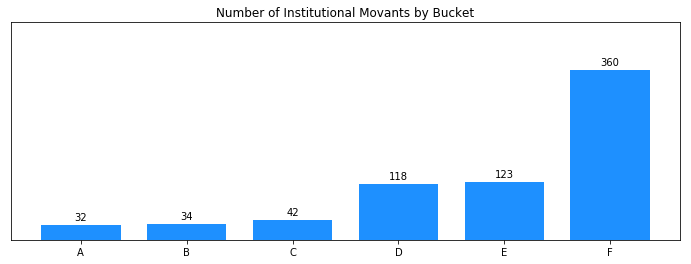

In [83]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Institutional Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### III.B Average Loss By Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [84]:
data_3b = data_3[['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3b_describe = data_3b.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3b_describe = data_3b_describe.describe()

In [85]:
pd.options.display.float_format = '{:.0f}'.format
data_3b_describe

Damage Bucket,A,B,C,D,E,F
count,32,34,42,117,117,351
mean,466336,410495,442968,695454,1153065,3465671
std,1365148,557007,898744,1517956,2921750,7572463
min,875,5401,1559,112,1609,2700
25%,50178,84905,52432,107970,123654,275101
50%,136731,146034,152792,248948,303220,795783
75%,281768,669567,391554,601702,990919,2485592
max,7793640,2479670,4725022,11577603,23517243,64910560


#### III.C. Average Loss By Winning Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [86]:
data_3c = data_3[data_3.win==1][['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3c_describe = data_3c.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3c_describe = data_3c_describe.describe()

In [87]:
data_3c_describe

Damage Bucket,A,B,C,D,E,F
count,21,16,24,56,52,135
mean,631492,536168,439192,1049547,1285646,5049329
std,1668629,724723,725355,2039906,2408766,9659453
min,16160,5401,6371,500,32033,24957
25%,83829,84368,104283,181619,131211,394556
50%,181978,159356,262681,317937,364113,1415365
75%,385918,727470,463685,940687,1211570,5095464
max,7793640,2479670,3666926,11577603,13032286,64910560


#### III.D. Average AUM of Institutional Movant by Bucket
##### Note: Count Includes Only Institutional Movants with AUMs (no N/As)

In [88]:
data_3d = main[['Damage Bucket',  "Institutional Movant", "AUM"]].dropna()
data_3d_describe = data_3d.pivot(columns = 'Damage Bucket', values = 'AUM')
data_3d_describe = data_3d_describe.describe()

In [92]:
pd.options.display.float_format = '${:,.0f}'.format
data_3d_describe

Damage Bucket,A,B,C,D,E,F
count,$16,$19,$26,$97,$101,$303
mean,"$2,088,157,686","$3,788,363,971","$11,190,254,133","$4,100,593,480","$12,423,699,794","$37,333,336,611"
std,"$4,039,244,434","$7,160,045,909","$47,327,837,378","$14,431,406,900","$38,554,857,229","$123,323,704,393"
min,"$801,120","$12,000,000","$517,000","$23,351,741","$517,000","$517,000"
25%,"$20,875,000","$381,315,000","$107,233,000","$365,560,000","$302,890,000","$470,168,750"
50%,"$259,562,406","$762,562,834","$504,367,917","$884,718,824","$1,013,288,083","$2,594,738,556"
75%,"$1,370,571,337","$2,178,642,302","$1,412,524,951","$2,130,049,570","$3,247,579,403","$14,406,000,000"
max,"$14,406,000,000","$28,766,141,000","$242,262,242,175","$135,270,275,000","$242,262,242,175","$1,515,000,000,000"


#### III.E. Frequent Flyer Analysis

#### III.E.1. Movant Type

In [93]:
data_3e = main[["Institutional Movant", "Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", 'Investor Frequent Flyer', 'Movant Loss', "Filing Firm"]]
data_3e = data_3e[~data_3e["Institutional Movant"].isna()]
data_3e.loc[(data_3e["Investor Frequent Flyer"].isna()),"Investor Frequent Flyer"] = "NotFF"

In [94]:
data_3e1 = data_3e.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")

In [95]:
y_val1 = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Institutional Movant"]
y_val2 = data_3e1[data_3e1["Investor Frequent Flyer"]== "NotFF"]["Institutional Movant"]
x_val = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]

In [96]:
data_3e1

,"Type (Ind, Ins, G-Ind, G-Ins, G-Mix)",Investor Frequent Flyer,Institutional Movant
0,G-Ins,FF,142
1,G-Ins,NotFF,92
2,G-Mix,FF,14
3,G-Mix,NotFF,51
4,Ins,FF,255
5,Ins,NotFF,161


#### III.E.2.By Bucket

In [97]:
data_3e2 = data_3e.groupby(["Damage Bucket", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Damage Bucket")

In [98]:
data_3e2

,Damage Bucket,Investor Frequent Flyer,Institutional Movant
0,A,FF,11
1,A,NotFF,21
2,B,FF,14
3,B,NotFF,20
4,C,FF,18
5,C,NotFF,24
6,D,FF,67
7,D,NotFF,51
8,E,FF,69
9,E,NotFF,54


#### III.E.3.By Filing Firm

In [132]:
data_3e3 = main[["Movant", "Institutional Movant", "Company Name","Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Type", 'Investor Frequent Flyer', 'Movant Loss', "Firm Names - Movant", "AUM"]]
data_3e3.loc[(data_3e3["Investor Frequent Flyer"].isna()) & (data_3e3["Type"]=="Institution"),"Investor Frequent Flyer"] = "NotFF"

In [133]:
data_3e3_count = data_3e3.groupby("Movant")["Type"].count().reset_index().rename(columns = {"Type": "case_count"})

In [134]:
data_3e3 = data_3e3.merge(data_3e3_count, how = "left", on = "Movant")

In [135]:
data_3e3_repeat = data_3e3[data_3e3.case_count > 1].sort_values(["Type","Movant", "Firm Names - Movant"])
data_3e3_repeat["Movant Loss"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)
data_3e3_repeat["AUM"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)

In [137]:
data_3e3_repeat_ind = data_3e3_repeat[data_3e3_repeat.Type == "Individual"][["Movant","Firm Names - Movant", "Company Name", "Movant Loss"]]
data_3e3_repeat_ins = data_3e3_repeat[data_3e3_repeat.Type == "Institution"][["Movant","AUM","Firm Names - Movant", "Company Name", "Movant Loss"]]

In [139]:
with pd.ExcelWriter('FrequentFlyerAnalysis_3rdPass.xlsx') as writer:  # doctest: +SKIP
    data_3e3_repeat_ind.to_excel(writer, sheet_name='Individual', index = False)
    data_3e3_repeat_ins.to_excel(writer, sheet_name='Institution', index = False)

### APPENDIX

plt.clf()
plt.bar(x_val, y_val, color="b")
plt.title('Number of Cases by Bucket')
plt.show()

plt.clf()
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
ticks = np.array([2,4,6,8,10])

plt.title('Number of Institutional Movants by Bucket')

ax.bar(ticks, y_val1, width, color = "blue")
ax.bar(ticks + np.repeat(width, len(x_val)), y_val2, width, color = "orange")

plt.yticks([], [])

ax.set_ylim([0,y_val2.max()+ 100])

rects = ax.patches
ax.yaxis.set_ticks_position('none')

for i in range(len(x_val)):
    height = rects[i].get_height()
    ax.text(rects[i].get_x() + rects[i].get_width() / 2, height + 5, y_val1[i],
            ha='center', va='bottom')
    ax.text(rects[i].get_x() + rects[i].get_width() / 2, height + 5, y_val2[i],
            ha='center', va='bottom')
    
plt.xticks(ticks, c_val)

plt.show()

#### Number of Cases by Bucket

y_val = datapull['Damage Bucket'].value_counts().sort_index()
x_val = datapull['Damage Bucket'].value_counts().sort_index().index

plt.clf()
plt.bar(x_val, y_val, color="b")
plt.show()

bucketmovantcount = main['Damage Bucket'].value_counts().sort_index()

bucketmovantcount

fig, ax = plt.subplots() 

ind = np.arange(len(y_val))
bar_width = 0.75

ax.bar(ind, y_val, bar_width, col = 'b')
for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), color='blue')

plt.title('Number of Classes by Bucket', size = 16)

fig.tight_layout()

plt.show()

buckets = main["Damage Bucket"].sort_values().dropna().unique()
types = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].sort_values().dropna().unique()

xval = buckets
yval = []

for i in buckets: 
    yval.append(data_2c_grouped[i][types])

plt.clf()
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
ticks = np.array([2,4,6,8,10])

plt.title('Number of Movants by Type for Each Bucket')

for i in yval
ax.bar(ticks, y_val1, width, color = "blue")
ax.bar(ticks + np.repeat(width, len(x_val)), y_val2, width, color = "orange")

plt.yticks([], [])

ax.set_ylim([0,y_val2.max()+ 100])

rects = ax.patches
ax.yaxis.set_ticks_position('none')

for i in range(len(x_val)):
    height = rects[i].get_height()
    ax.text(rects[i].get_x() + rects[i].get_width() / 10 + , height + 5, y_val1[i],
            ha='center', va='bottom')
    ax.text(rects[i].get_x() + rects[i].get_width() / i*2, height + 5, y_val2[i],
            ha='center', va='bottom')
    
plt.xticks(ticks, c_val)

plt.show()